C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	100   
1  	83    
2  	77    
3  	80    
4  	73    
5  	79    
6  	75    
7  	78    
8  	81    
9  	85    
10 	75    
11 	76    
12 	80    
13 	83    
14 	76    
15 	78    
16 	76    
17 	67    
18 	83    
19 	75    
20 	76    
21 	85    
22 	80    
23 	80    
24 	80    
25 	74    
26 	85    
27 	80    
28 	74    
29 	76    
30 	80    
31 	61    
32 	67    
33 	72    
34 	77    
35 	81    
36 	87    
37 	74    
38 	75    
39 	82    
40 	64    
Accuracy:  0.8649289099526066
              precision    recall  f1-score   support

       False       0.88      0.98      0.93       363
        True       0.56      0.15      0.24        59

    accuracy                           0.86       422
   macro avg       0.72      0.57      0.58       422
weighted avg       0.83      0.86      0.83       422



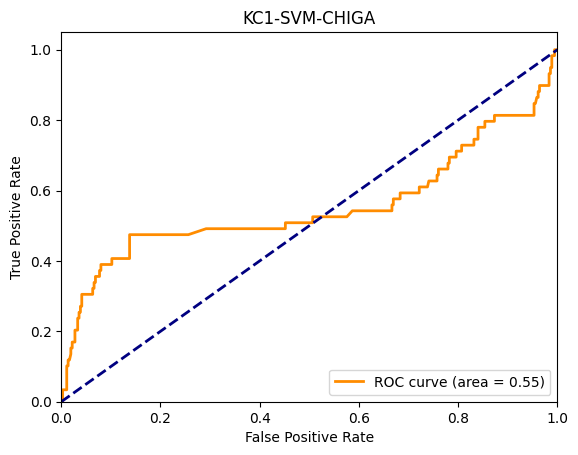

In [2]:
# Required libraries
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report
import matplotlib.pyplot as plt
from deap import creator, base, tools, algorithms

# Load dataset from CSV
data = pd.read_csv('./kc1.csv')

# Assuming the last column is the target and the rest are features
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Create the selector object
selector = SelectKBest(chi2, k="all")
X_new = selector.fit_transform(X, y)

# Access the scores attribute to rank features
ranked_features = np.argsort(-selector.scores_)

# Genetic Algorithm for feature selection
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.choice, [0, 1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, X_new.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Define the evaluation function
def evalOneMax(individual):
    selected_features = [ranked_features[i] for i, val in enumerate(individual) if val == 1]
    X_train, X_valid, y_train, y_valid = train_test_split(X[:, selected_features], y, test_size=0.2)
    clf = SVC()
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_valid)
    accuracy = accuracy_score(y_valid, predictions)
    return accuracy,

toolbox.register("evaluate", evalOneMax)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=100)
ngen = 40
crossover_prob = 0.7
mutation_prob = 0.2

algorithms.eaSimple(population, toolbox, crossover_prob, mutation_prob, ngen, stats=None, 
                    halloffame=None, verbose=True)

# Extract the best individual and get the corresponding feature subset
best_ind = tools.selBest(population, 1)[0]
best_features = [ranked_features[i] for i, val in enumerate(best_ind) if val == 1]

# Train and evaluate the SVM model with the best features
X_train, X_test, y_train, y_test = train_test_split(X[:, best_features], y, test_size=0.2)
clf = SVC(probability=True)
clf.fit(X_train, y_train)
final_predictions = clf.predict(X_test)
final_accuracy = accuracy_score(y_test, final_predictions)

# Test the classifier
print("Accuracy: ", accuracy_score(y_test, final_predictions))
print(classification_report(y_test, final_predictions))

# Plot the AUC-ROC curve
probas_ = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, probas_[:, 1]) 
roc_auc = auc(fpr, tpr)

#Save AUC values
df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'AUC': roc_auc
})
df.to_csv('./AUC_Extracts/KC1/KC1_SVM_CHIGA.csv', index=False)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KC1-SVM-CHIGA')
plt.legend(loc="lower right")
plt.show()
